# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [42]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [43]:
df.shape

(45993, 3)

In [44]:
df_content.shape

(1056, 5)

Median number of articles interacted with: 3.0
Maximum number of articles interacted with by a single user: 364


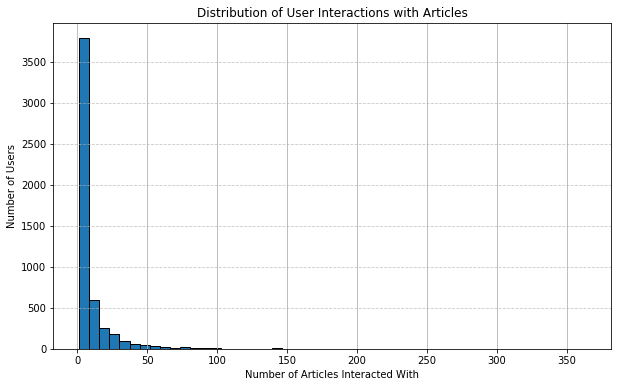

In [45]:
# Group by email (user) and count the number of interactions (articles interacted with)
user_article_interactions = df.groupby('email')['article_id'].count()

# Descriptive statistics
median_val = user_article_interactions.median()  # Median number of interactions
max_views_by_user = user_article_interactions.max()  # Maximum interactions by any one user

# Print results
print(f"Median number of articles interacted with: {median_val}")
print(f"Maximum number of articles interacted with by a single user: {max_views_by_user}")

# Visualization of the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
user_article_interactions.hist(bins=50, edgecolor='black')
plt.title('Distribution of User Interactions with Articles')
plt.xlabel('Number of Articles Interacted With')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [46]:
# Find and explore duplicate articles in df_content based on article_id
duplicate_articles = df_content[df_content.duplicated(subset='article_id')]
print(f"Number of duplicate articles: {len(duplicate_articles)}")
print("Sample duplicate articles:")
print(duplicate_articles.head())

Number of duplicate articles: 5
Sample duplicate articles:
                                              doc_body  \
365  Follow Sign in / Sign up Home About Insight Da...   
692  Homepage Follow Sign in / Sign up Homepage * H...   
761  Homepage Follow Sign in Get started Homepage *...   
970  This video shows you how to construct queries ...   
971  Homepage Follow Sign in Get started * Home\r\n...   

                                       doc_description  \
365  During the seven-week Insight Data Engineering...   
692  One of the earliest documented catalogs was co...   
761  Today’s world of data science leverages data f...   
970  This video shows you how to construct queries ...   
971  If you are like most data scientists, you are ...   

                                         doc_full_name doc_status  article_id  
365                       Graph-based machine learning       Live          50  
692  How smart catalogs can turn the big data flood...       Live         221  
761

In [47]:
# Remove duplicates, keeping only the first occurrence
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

# Verify removal of duplicates
remaining_duplicates = df_content[df_content.duplicated(subset='article_id')]
print(f"Number of duplicate articles after removal: {len(remaining_duplicates)}")


Number of duplicate articles after removal: 0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [48]:
# a. The number of unique articles that have an interaction with a user
unique_articles = df['article_id'].nunique()
print(f"The number of unique articles that have at least one interaction: {unique_articles}")

# b. The number of unique articles in the dataset (whether they have any interactions or not)
total_articles = df_content['article_id'].nunique()
print(f"The total number of unique articles on the IBM platform: {total_articles}")

# c. The number of unique users in the dataset (excluding null values)
unique_users = df['email'].nunique()
print(f"The number of unique users in the dataset: {unique_users}")

# d. The number of user-article interactions in the dataset
user_article_interactions = df.shape[0]
print(f"The total number of user-article interactions in the dataset: {user_article_interactions}")


The number of unique articles that have at least one interaction: 714
The total number of unique articles on the IBM platform: 1051
The number of unique users in the dataset: 5148
The total number of user-article interactions in the dataset: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [49]:
# Find the most viewed article and how often it was viewed
most_viewed_article_id = str(df['article_id'].value_counts().idxmax())  # ID of the most viewed article as a string
max_views = df['article_id'].value_counts().max()  # Number of views for the most viewed article

# Display the results
print(f"The most viewed article ID is: {most_viewed_article_id}")
print(f"The most viewed article was viewed {max_views} times.")

The most viewed article ID is: 1429.0
The most viewed article was viewed 937 times.


In [50]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [51]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [52]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    DESCRIPTION:
    This function returns the top 'n' article titles based on the number of interactions.
    '''
    # Count the interactions for each article and sort in descending order
    top_articles = (
        df.groupby('article_id')
          .size()
          .sort_values(ascending=False)
          .head(n)
          .index
    )
    
    # Map the article IDs to titles
    top_articles = df[df['article_id'].isin(top_articles)]['title'].unique().tolist()
    
    return top_articles


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids as strings 
    
    Description:
    Returns the top 'n' article IDs based on the number of user interactions.
    '''
    # Count the interactions for each article and sort by count in descending order
    top_articles = (
        df['article_id']
        .value_counts()
        .head(n)
        .index
        .astype(str)
        .tolist()
    )
    
    return top_articles



In [53]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [54]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [55]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - pandas dataframe
        A user-item matrix with user ids as rows and article ids as columns, 
        where the values are 1 if a user interacted with an article and 0 otherwise.
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values 
    where a user interacted with an article and 0 otherwise.
    '''
    # Create the user-item matrix
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack(fill_value=0)
    
    # Convert counts to binary (1 if interaction exists, 0 otherwise)
    user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item

# Create the user-item matrix
user_item = create_user_item_matrix(df)

# Display the shape and a snippet of the matrix
print(f"User-item matrix shape: {user_item.shape}")
user_item.head()


User-item matrix shape: (5149, 714)


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [57]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of users based on similarity.
    '''
    # Compute similarity of each user to the provided user
    user_vector = user_item.loc[user_id]  # Get the row for the user
    similarity = user_item.dot(user_vector)  # Compute dot product for all users

    # Sort by similarity in descending order and exclude the provided user
    similarity = similarity.sort_values(ascending=False)
    most_similar_users = similarity.index[similarity.index != user_id].tolist()

    return most_similar_users  # Return a list of the users in order from most to least similar


In [58]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [59]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids as strings
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Filter the dataframe for the provided article IDs and extract unique titles
    article_names = []
    for i in article_ids:
        name = df[df['article_id'] == float(i)]['title'].iloc[0]
    
        article_names.append(name)
    
    return article_names




def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user as strings
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Find the articles the user has interacted with (values = 1)
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    
    # Get article names based on article IDs
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names




def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    '''
    # Find the most similar users to the input user
    similar_users = find_similar_users(user_id, user_item)
    
    # Get the articles the input user has already seen
    seen_article_ids, _ = get_user_articles(user_id, user_item)
    
    # Initialize recommendations
    recs = set()
    
    # Loop through similar users to get recommendations
    for sim_user in similar_users:
        # Get articles for the similar user
        sim_user_article_ids, _ = get_user_articles(sim_user, user_item)
        
        # Find new articles (not seen by the input user)
        new_recs = set(sim_user_article_ids) - set(seen_article_ids)
        
        # Add to the recommendations
        recs.update(new_recs)
        
        # Stop when we have enough recommendations
        if len(recs) >= m:
            break
    
    # Return the top m recommendations
    return list(recs)[:m]
 

In [60]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['insights from new york car accident reports',
 '502    forgetting the past to learn the future: long ...\nName: title, dtype: object',
 'optimizing a marketing campaign: moving from predictions to actions',
 'declarative machine learning',
 'analyze open data sets with spark & pixiedust',
 'leverage python, scikit, and text classification for behavioral profiling',
 'experience iot with coursera',
 'build a python app on the streaming analytics service',
 'healthcare python streaming application demo',
 'spark-based machine learning tools for capturing word meanings']

In [61]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [62]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) the user ID for whom to find similar users
    df - (pandas dataframe) interaction dataframe with article_id, user_id, title
    user_item - (pandas dataframe) user-item matrix with 1's for interaction and 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - the ID of the neighboring user
                    similarity - the dot product similarity to the given user
                    num_interactions - the number of articles viewed by the neighbor
                    
    Description:
    Compute the similarity of the given user to all other users and rank neighbors first 
    by similarity and then by number of interactions (descending for both).
    '''
    # Compute similarity (dot product)
    user_vector = user_item.loc[user_id]
    similarity = user_item.dot(user_vector)
    
    # Create dataframe for neighbors
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity.index,
        'similarity': similarity.values
    })
    
    # Remove the given user from the neighbors
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # Add number of interactions for each neighbor
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(
        lambda x: df[df['user_id'] == x].shape[0]
    )
    
    # Sort by similarity (descending) and number of interactions (descending)
    neighbors_df = neighbors_df.sort_values(
        by=['similarity', 'num_interactions'], ascending=[False, False]
    )
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Generate article recommendations for a user based on similar users, prioritizing users
    with the most interactions and articles with the most interactions.
    '''
    # Get similar users sorted by similarity and number of interactions
    neighbors_df = get_top_sorted_users(user_id)
    
    # Get articles the user has already seen
    seen_article_ids, _ = get_user_articles(user_id, user_item)
    
    # Initialize recommendations
    recs = []
    
    # Loop through similar users to find recommendations
    for neighbor_id in neighbors_df['neighbor_id']:
        # Get articles seen by this neighbor
        neighbor_article_ids, _ = get_user_articles(neighbor_id, user_item)
        
        # Find new articles for the input user
        new_recs = set(neighbor_article_ids) - set(seen_article_ids)
        
        # Rank new articles by their interaction count
        ranked_recs = (
            df[df['article_id'].isin(new_recs)]
            .groupby('article_id')
            .size()
            .sort_values(ascending=False)
            .index.tolist()
        )
        
        # Add to recommendations
        recs.extend(ranked_recs)
        
        # Stop if we have enough recommendations
        if len(recs) >= m:
            break
    
    # Limit recommendations to m articles
    recs = recs[:m]
    
    # Get article names for the recommendations
    rec_names = get_article_names(recs, df)
    
    return recs, rec_names


In [63]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [64]:
### Tests with a dictionary of results

# Find the most similar user to user 1
user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id']

In [65]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

If we were given a new user, we could use the get_top_articles() function, which leverages rank-based recommendations. Since the new user has not interacted with any articles yet, collaborative filtering cannot be applied to identify similar articles or users.









`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [66]:
# Recommendations for a new user
def get_new_user_recommendations(n=10, df=df):
    '''
    INPUT:
    n - (int) number of recommendations to return
    df - (pandas dataframe) original dataframe containing article interactions
    
    OUTPUT:
    new_user_recs - (list) list of the top 'n' article ids based on popularity
    
    Description:
    Provides recommendations for a new user based on the most interacted articles in the dataset.
    '''
    # Get the top n article ids based on interaction count
    new_user_recs = get_top_article_ids(n, df)
    
    return new_user_recs

# Example: Get recommendations for the new user
new_user = '0.0'
new_user_recs = get_new_user_recommendations(10)
print(f"The top 10 recommended articles for the new user ({new_user}) are: {new_user_recs}")


The top 10 recommended articles for the new user (0.0) are: ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [67]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [68]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [69]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [70]:
import numpy as np

# Perform Singular Value Decomposition
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)

# Display the shapes of the matrices
print(f"Shape of U: {u.shape}")
print(f"Shape of S: {s.shape}")
print(f"Shape of V^T: {vt.shape}")


Shape of U: (5149, 714)
Shape of S: (714,)
Shape of V^T: (714, 714)


**Provide your response here.**

We can use the built-in SVD function because the user_item_matrix contains no NaN values. Before performing SVD, all NaN values were replaced with 0 in the user-item matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

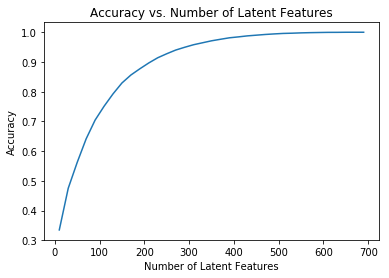

In [71]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [72]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    Description:
    Creates user-item matrices for training and testing datasets and extracts test user ids 
    and article ids.
    '''
    # Create user-item matrices
    user_item_train = df_train.pivot_table(index='user_id', columns='article_id', 
                                           aggfunc='size', fill_value=0)
    user_item_test = df_test.pivot_table(index='user_id', columns='article_id', 
                                         aggfunc='size', fill_value=0)
    
    # Extract unique user IDs and article IDs for the test set
    test_idx = user_item_test.index.tolist()  # Test user IDs
    test_arts = user_item_test.columns.tolist()  # Test article IDs
    
    return user_item_train, user_item_test, test_idx, test_arts

# Create user-item matrices for training and testing
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


# Users we can make predictions for
predictable_users = set(test_idx).intersection(set(user_item_train.index))
print(f"Number of users we can make predictions for: {len(predictable_users)}")

# Users we cannot make predictions for
cold_start_users = set(test_idx) - set(user_item_train.index)
print(f"Number of users we cannot make predictions for: {len(cold_start_users)}")

# Articles we can make predictions for
predictable_articles = set(test_arts).intersection(set(user_item_train.columns))
print(f"Number of articles we can make predictions for: {len(predictable_articles)}")

# Articles we cannot make predictions for
cold_start_articles = set(test_arts) - set(user_item_train.columns)
print(f"Number of articles we cannot make predictions for: {len(cold_start_articles)}")


Number of users we can make predictions for: 20
Number of users we cannot make predictions for: 662
Number of articles we can make predictions for: 574
Number of articles we cannot make predictions for: 0


In [73]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [74]:
# Perform SVD on the training user-item matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

# Display the shapes of the matrices
print(f"Shape of U (train): {u_train.shape}")
print(f"Shape of S (train): {s_train.shape}")
print(f"Shape of V^T (train): {vt_train.shape}")

Shape of U (train): (4487, 714)
Shape of S (train): (714,)
Shape of V^T (train): (714, 714)


In [75]:
# Filter the test dataset to users and articles present in the training set
common_users = set(user_item_test.index).intersection(set(user_item_train.index))
common_articles = set(user_item_test.columns).intersection(set(user_item_train.columns))

# Subset user-item matrices to only include common users and articles
user_item_test_subset = user_item_test.loc[common_users, common_articles]
u_test = u_train[user_item_train.index.isin(common_users), :]
vt_test = vt_train[:, user_item_train.columns.isin(common_articles)]


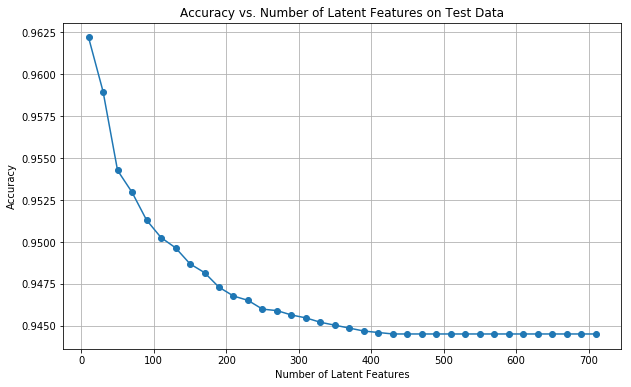

In [76]:
num_latent_feats = np.arange(10, len(s_train) + 10, 20)
sum_errs = []

for k in num_latent_feats:
    # Reduce to k latent features
    u_k, s_k, vt_k = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    
    # Reconstruct the user-item matrix for the test subset
    user_item_test_pred = np.dot(np.dot(u_k, s_k), vt_k)
    
    # Align the predictions to the test subset
    test_pred_subset = user_item_test_pred[
        user_item_train.index.isin(common_users), :
    ][:, user_item_train.columns.isin(common_articles)]
    
    # Round predictions to nearest 1 or 0
    test_pred_binary = np.around(test_pred_subset)
    
    # Compute the error
    diffs = np.subtract(user_item_test_subset, test_pred_binary)
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

# Plot accuracy vs. number of latent features
plt.figure(figsize=(10, 6))
plt.plot(num_latent_feats, 1 - np.array(sum_errs) / user_item_test_subset.size, marker='o')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features on Test Data')
plt.grid(True)
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

#### Code required to get more data to base analysis on:

In [77]:
# Extract accuracy values from the plot in question 5
accuracy_values = 1 - np.array(sum_errs) / user_item_test_subset.size
optimal_latent_features = num_latent_feats[np.argmax(accuracy_values)]  # Number of latent features with highest accuracy

print(f"Accuracy values: {accuracy_values}")
print(f"Optimal number of latent features: {optimal_latent_features}")


Accuracy values: [ 0.96219512  0.95897213  0.95426829  0.95296167  0.95130662  0.95026132
  0.94965157  0.94869338  0.94817073  0.94729965  0.946777    0.94651568
  0.94599303  0.94590592  0.9456446   0.94547038  0.94520906  0.94503484
  0.94486063  0.94468641  0.9445993   0.9445122   0.9445122   0.9445122
  0.9445122   0.9445122   0.9445122   0.9445122   0.9445122   0.9445122
  0.9445122   0.9445122   0.9445122   0.9445122   0.9445122   0.9445122 ]
Optimal number of latent features: 10


In [78]:
# Cold start problem statistics
print(f"Number of users in training set: {user_item_train.shape[0]}")
print(f"Number of users in testing set: {user_item_test.shape[0]}")
print(f"Number of users we can predict for: {len(predictable_users)}")
print(f"Number of users we cannot predict for (cold start): {len(cold_start_users)}")

print(f"Number of articles in training set: {user_item_train.shape[1]}")
print(f"Number of articles in testing set: {user_item_test.shape[1]}")
print(f"Number of articles we can predict for: {len(predictable_articles)}")
print(f"Number of articles we cannot predict for (cold start): {len(cold_start_articles)}")


Number of users in training set: 4487
Number of users in testing set: 682
Number of users we can predict for: 20
Number of users we cannot predict for (cold start): 662
Number of articles in training set: 714
Number of articles in testing set: 574
Number of articles we can predict for: 574
Number of articles we cannot predict for (cold start): 0


In [79]:
# Average engagement per user (example metric: number of interactions per user)
avg_engagement_per_user = df.groupby('user_id').size().mean()
print(f"Average user engagement (interactions per user): {avg_engagement_per_user}")

# Total interactions per article
article_engagement = df.groupby('article_id').size().sort_values(ascending=False)
print("Top 5 articles by engagement:")
print(article_engagement.head(5))


Average user engagement (interactions per user): 8.932414060982715
Top 5 articles by engagement:
article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
dtype: int64


**Your response here.**

## 1.  Accuracy and Optimal Number of Latent Features

#### Accuracy Values:
Accuracy starts at approximately 96.2% with 10 latent features and gradually declines as more features are added, stabilizing at around 94.4%.
This indicates that using too many latent features introduces noise rather than improving predictions, likely due to overfitting to the training data.

#### Optimal Latent Features:
The optimal number of latent features is 10, where accuracy is the highest.
This low number suggests that the user-item interactions are well-explained by a small set of latent factors.

## 2. Cold Start Problem

#### Users:
Out of 682 users in the test set, predictions can be made for only 20 users, while 662 users face the cold start problem.
This highlights a significant limitation of the collaborative filtering approach, as it relies heavily on overlapping users between the training and testing datasets.

#### Articles:
All 574 articles in the test set overlap with the training set, so no articles are impacted by the cold start problem.
This is a favorable outcome, as it ensures that article predictions can be made for all users who have some overlap.

## 3. User Engagement

#### Average Engagement:
On average, users interact with approximately 9 articles, indicating a reasonable level of user activity.
Engagement data can be useful for designing content recommendations, as highly engaged users might benefit more from personalized recommendations.

#### Top Articles by Engagement:
Articles with IDs 1429.0, 1330.0, and 1431.0 are the most popular, with 1429.0 having the highest engagement (937 interactions).
These articles are likely to appear in recommendations for new users or as fallback suggestions in cases of sparse user data.

## 4. Recommendations to Improve the System

#### Cold Start Problem:
Use content-based filtering for new users and users in the cold start category. Articles can be recommended based on metadata, such as topic, tags, or popularity.
Incorporate hybrid approaches combining collaborative and content-based filtering.

#### Accuracy Validation:
Beyond reconstructing the user-item matrix, validate recommendations using metrics like precision, recall, or F1 score on held-out test data.
Consider user-level metrics, such as click-through rates or time spent on recommended articles.

#### Improve Metadata Mapping:
Fix the get_article_names function to ensure proper title retrieval for recommendations.
Ensure consistent data types and alignment between article IDs in df and the recommendation output.
Diversity in Recommendations:

Current recommendations focus heavily on popular articles. Introduce mechanisms to diversify recommendations, exposing users to a wider variety of content.

## 5. Testing the Recommendation Engine in Practice
To evaluate the recommendation engine, an A/B test can be conducted:

- Divide users into a control group (existing method) and a test group (new method).
- Measure metrics like click-through rate (CTR), engagement time, and conversion rate to assess performance.
- Use statistical tests (e.g., t-test) to determine if improvements are significant.

 For a baseline, we could compare the new engine against simple strategies like recommending the most popular articles. Address challenges like the cold start problem by using content-based methods for new users. This iterative testing ensures practical effectiveness and continuous improvement.

In [80]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0